In [40]:
#Import libraries
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import squarify as sq
from matplotlib.ticker import PercentFormatter
from fim import arules
from operator import attrgetter
import matplotlib.colors as mcolors
warnings.filterwarnings("ignore")
import matplotlib.ticker as tkr

#Use fivethirtyeight style
plt.style.use('fivethirtyeight')

#Cancel any style and reset matplotlib styles
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

In [44]:
#Read File

df =pd.read_excel('Online Retail.xlsx')
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  CustomerID         Country  
0      2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1      2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2      2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3      2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4      2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
...                    ...        ...         ...             ...  
541904 2011-12-09 12:50:00       0.85     12680.0          France  
541905 2011-12-09 12:50:00       2.10     12680.0          France  
541906 2011-12-09 12:50:00       4.15     12680.0          France  
541907 2011-12-09 12:50:00       4.15     12680.0          France  
541908 2011-12-09 12:50:00       4.95     12680.0          France  

[541909 rows x 8 columns]

## Variables

InvoiceNo: BillNo number. A unique number for each transaction.

StockCode: Stock Code for each product

Description: Product description.

Quantity: It refers to how many of the products in the invoices have been sold.

InvoiceDate: Invoice date.

UnitPrice: Product price (pound)

CustomerID: Unique customer number.

Country: The name of the country where the customer lives.

In [4]:
#Check Dataframe's info

def check_df(dataframe):
    print("--- Shape ---\n")
    print(dataframe.shape)
    print("\n\n--- Columns ---\n")
    print(dataframe.columns)
    print("\n\n--- Types ---")
    print(dataframe.dtypes)
check_df(df)


--- Shape ---

(541909, 8)


--- Columns ---

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')


--- Types ---
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object


In [4]:
# Dataframe Description

df.describe()

Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000

In [45]:
# Keep only logical values for Quantity and UnitPrice, meaning x > 0

df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]


#Examine stats again
df.describe()

Quantity      UnitPrice     CustomerID
count  530104.000000  530104.000000  397884.000000
mean       10.542037       3.907625   15294.423453
std       155.524124      35.915681    1713.141560
min         1.000000       0.001000   12346.000000
25%         1.000000       1.250000   13969.000000
50%         3.000000       2.080000   15159.000000
75%        10.000000       4.130000   16795.000000
max     80995.000000   13541.330000   18287.000000

In [46]:
#Check %of missing values

df.isnull().sum() * 100 / len(df)

InvoiceNo       0.000000
StockCode       0.000000
Description     0.000000
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.942275
Country         0.000000
dtype: float64

In [47]:
#Remove the missing observations from the dataset

df.dropna(inplace=True)
df.describe()

Quantity      UnitPrice     CustomerID
count  397884.000000  397884.000000  397884.000000
mean       12.988238       3.116488   15294.423453
std       179.331775      22.097877    1713.141560
min         1.000000       0.001000   12346.000000
25%         2.000000       1.250000   13969.000000
50%         6.000000       1.950000   15159.000000
75%        12.000000       3.750000   16795.000000
max     80995.000000    8142.750000   18287.000000

## EDA

In [424]:
#How many unique items in the dataset?
df["Description"].nunique()

3877

In [425]:
#How many product in the dataset?
df["Description"].value_counts()

WHITE HANGING HEART T-LIGHT HOLDER    2028
REGENCY CAKESTAND 3 TIER              1723
JUMBO BAG RED RETROSPOT               1618
ASSORTED COLOUR BIRD ORNAMENT         1408
PARTY BUNTING                         1396
                                      ... 
RUBY GLASS CLUSTER EARRINGS              1
PINK CHRYSANTHEMUMS ART FLOWER           1
72 CAKE CASES VINTAGE CHRISTMAS          1
WALL ART , THE MAGIC FOREST              1
PAPER CRAFT , LITTLE BIRDIE              1
Name: Description, Length: 3877, dtype: int64

In [436]:
type(df['CustomerID'][0])

numpy.float64

In [48]:
#Convert CustomerID into string to handle it better

df['CustomerID'] = df['CustomerID'].apply(int).apply(str)
df['CustomerID']

0         17850
1         17850
2         17850
3         17850
4         17850
          ...  
541904    12680
541905    12680
541906    12680
541907    12680
541908    12680
Name: CustomerID, Length: 397884, dtype: object

In [49]:
# Convert InvoiceDate into datetime in case it wasn't before

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [50]:
# We have only Price per Unit and Quantity but not Total Sales.
#So we Create Total Sales Column by multiplying  Unit Price * Quantity

df["TotalSales"] = df["Quantity"] * df["UnitPrice"]
df

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice CustomerID         Country  TotalSales  
0      2010-12-01 08:26:00       2.55      17850  United Kingdom       15.30  
1      2010-12-01 08:26:00       3.39      17850  United Kingdom       20.34  
2      2010-12-01 08:26:00       2.75      17850  United Kingdom       22.00  
3      2010-12-01 08:26:00       3.39      17850  United Kingdom       20.34  
4      2010-12-01 08:26:00       3.39      17850  United Kingdom       20.34  
...                    ...        ...        ...             ...         ...  
541904 2011-12-09 12:50:00       0.85      12680          France       10.20  
541905 2011-12-09 12:50:00       2.10      12680          France       12.60  
541906 2011-12-09 12:50:00       4.15      12680          France       16.60  
541907 2011-12-09 12:50:00       4.15      12680          France       16.60  
541908 2011-12-09 12:50:00       4.95      12680          France       14.85  

[397884 rows x 9 columns]

In [51]:
#Examine number of transactions per customer 

customer_counts = df["CustomerID"].value_counts().sort_values(ascending=False).reset_index()
customer_counts.columns = ['CustomerID', 'count']
customer_counts

CustomerID  count
0         17841   7847
1         14911   5675
2         14096   5111
3         12748   4595
4         14606   2700
...         ...    ...
4333      15313      1
4334      13366      1
4335      18133      1
4336      18174      1
4337      17846      1

[4338 rows x 2 columns]

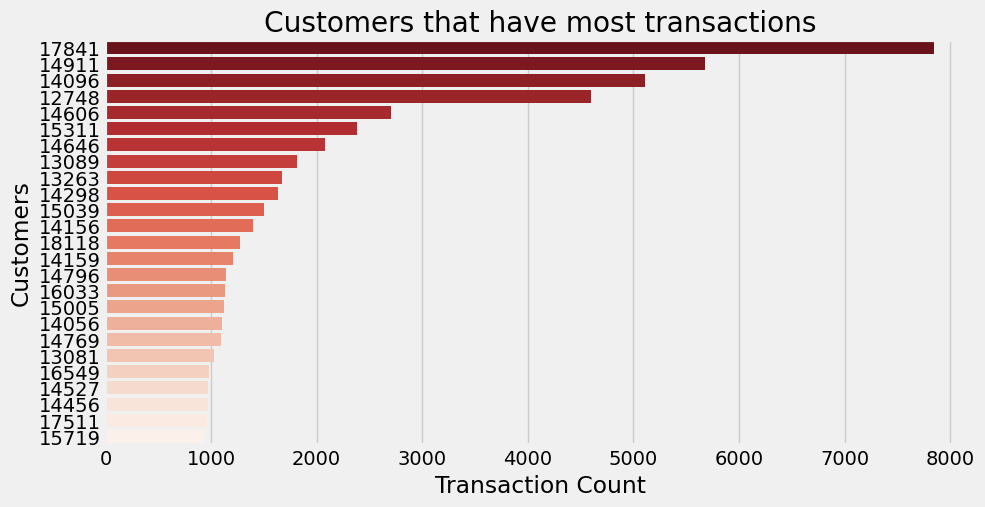

In [13]:
# Examine and Plot top25 customers

customer_counts_top25 = customer_counts.head(25)

fig, ax = plt.subplots(figsize = (10, 5))

sns.barplot(data=customer_counts_top25,x = customer_counts_top25["count"],y = customer_counts_top25["CustomerID"],
            order = customer_counts_top25["CustomerID"],  orient = 'h', palette = "Reds_r")

plt.title("Customers that have most transactions")
plt.ylabel("Customers")
plt.xlabel("Transaction Count")

plt.show()

In [52]:
#Examine Total Sales per Product

product_sales = df.groupby(['Description'])['TotalSales'].agg('sum').sort_values(ascending=False).reset_index()
product_sales

Description  TotalSales
0            PAPER CRAFT , LITTLE BIRDIE  168469.600
1               REGENCY CAKESTAND 3 TIER  142592.950
2     WHITE HANGING HEART T-LIGHT HOLDER  100448.150
3                JUMBO BAG RED RETROSPOT   85220.780
4         MEDIUM CERAMIC TOP STORAGE JAR   81416.730
...                                  ...         ...
3872          PURPLE FRANGIPANI HAIRCLIP       0.850
3873            VINTAGE BLUE TINSEL REEL       0.840
3874     SET 12 COLOURING PENCILS DOILEY       0.650
3875           HEN HOUSE W CHICK IN NEST       0.420
3876          PADS TO MATCH ALL CUSHIONS       0.003

[3877 rows x 2 columns]

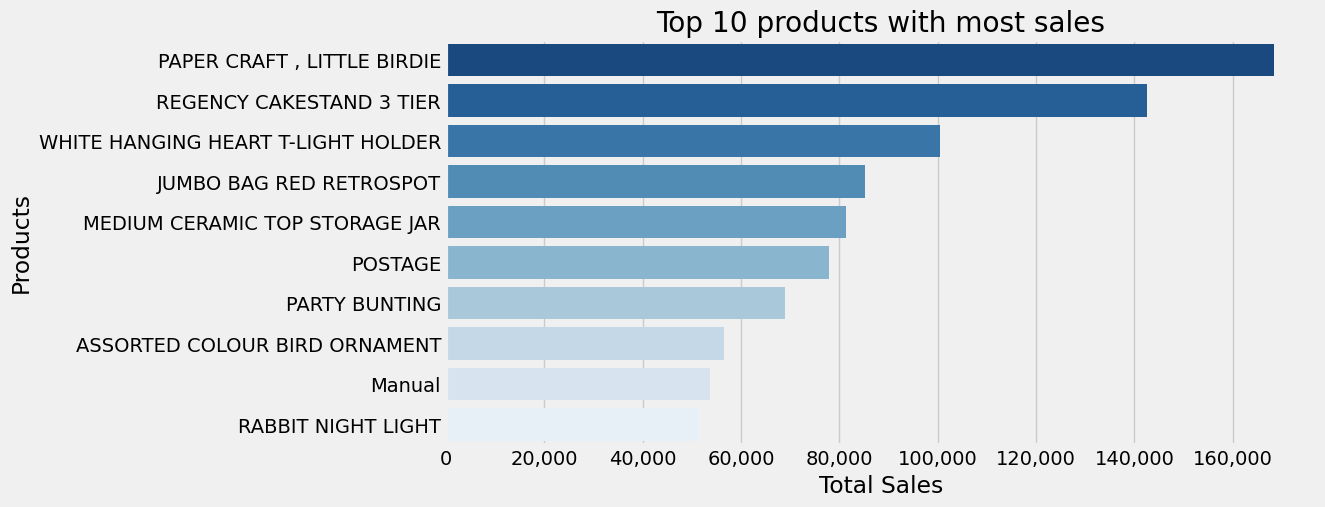

In [35]:
# Examine and Plot top10 Products according to Total Sales


product_sales_top10 = product_sales.head(10)

fig, ax = plt.subplots(figsize = (10, 5))

sns.barplot(data=product_sales_top10,x = product_sales_top10["TotalSales"],y = product_sales_top10["Description"],
            order = product_sales_top10["Description"],  orient = 'h', palette = "Blues_r")

plt.title("Top 10 products with most sales")
plt.ylabel("Products")
plt.xlabel("Total Sales")
ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda y,  p: format(int(y), ',')))

plt.show()

# RFM Analysis

In [53]:
# Find Recency. Take as reference day the maximum date

df['Recency'] = (df['InvoiceDate'].max() - df['InvoiceDate']).dt.days
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  TotalSales  \
0 2010-12-01 08:26:00       2.55      17850  United Kingdom       15.30   
1 2010-12-01 08:26:00       3.39      17850  United Kingdom       20.34   
2 2010-12-01 08:26:00       2.75      17850  United Kingdom       22.00   
3 2010-12-01 08:26:00       3.39      17850  United Kingdom       20.34   
4 2010-12-01 08:26:00       3.39      17850  United Kingdom       20.34   

   Recency  
0      373  
1      373  
2      373  
3      373  
4      373

##### Create RFM Table

 For each customer find:
 
 Recency : minimum Recency
 
 Frequency: count unique number of days of purchases
 
 Monetary: summary of Total Sales


In [54]:
rfm = df.groupby(["CustomerID"]).agg({'Recency': np.min,
                                      'InvoiceDate': pd.Series.nunique,
                                     'TotalSales': np.sum}).reset_index()


#Rename columns
rfm.rename(columns={'Recency':'Recency','InvoiceDate':'Frequency','TotalSales':'Monetary'},inplace= True)


rfm

CustomerID  Recency  Frequency  Monetary
0         12346      325          1  77183.60
1         12347        1          7   4310.00
2         12348       74          4   1797.24
3         12349       18          1   1757.55
4         12350      309          1    334.40
...         ...      ...        ...       ...
4333      18280      277          1    180.60
4334      18281      180          1     80.82
4335      18282        7          2    178.05
4336      18283        3         16   2094.88
4337      18287       42          3   1837.28

[4338 rows x 4 columns]

In [55]:
# Create Scores RFM scores based on quantiles of distribution

#Date from customer's last purchase.The nearest date gets 4 and the furthest date gets 1.
rfm["recency_score"] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])

# Total number of purchases.The least frequency gets 1 and the maximum frequency gets 4.
rfm["frequency_score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 4, labels=[1, 2, 3, 4])

#Total spend by the customer.The least money gets 1, the most money gets 4.
rfm["monetary_score"]= pd.qcut(rfm["Monetary"],4,labels=[1,2,3,4])

rfm.head()

CustomerID  Recency  Frequency  Monetary recency_score frequency_score  \
0      12346      325          1  77183.60             1               1   
1      12347        1          7   4310.00             4               4   
2      12348       74          4   1797.24             2               3   
3      12349       18          1   1757.55             3               1   
4      12350      309          1    334.40             1               1   

  monetary_score  
0              4  
1              4  
2              4  
3              4  
4              2

In [26]:
rfm["CustomerID"].nunique()

4338

In [56]:
rfm["RFM_Segment"] = rfm["recency_score"].astype(str) + rfm["frequency_score"].astype(str) + rfm["monetary_score"].astype(str)

rfm['RFM_Score'] = rfm[['recency_score','frequency_score','monetary_score']].sum(axis=1)
rfm.head()

CustomerID  Recency  Frequency  Monetary recency_score frequency_score  \
0      12346      325          1  77183.60             1               1   
1      12347        1          7   4310.00             4               4   
2      12348       74          4   1797.24             2               3   
3      12349       18          1   1757.55             3               1   
4      12350      309          1    334.40             1               1   

  monetary_score RFM_Segment  RFM_Score  
0              4         114          6  
1              4         444         12  
2              4         234          9  
3              4         314          8  
4              2         112          4

In [28]:
rfm.tail()

CustomerID  Recency  Frequency  Monetary recency_score frequency_score  \
4333      18280      277          1    180.60             1               2   
4334      18281      180          1     80.82             1               2   
4335      18282        7          2    178.05             4               3   
4336      18283        3         16   2094.88             4               4   
4337      18287       42          3   1837.28             3               3   

     monetary_score RFM_Segment  RFM_Score  
4333              1         121          4  
4334              1         121          4  
4335              1         431          8  
4336              4         444         12  
4337              4         334         10

In [57]:
# Use regex and dictionaries values to categorize numbers from customers
# 

segt_map = {
    r'[3-4][3-4]4': 'VIP',
    r'[2-3-4][1-2-3-4]4': 'Top Recent',
    r'1[1-2-3-4]4': 'Top at Risk ',

    
    
    r'[3-4][3-4]3': 'High Promising',
    r'[2-3-4][1-2]3': 'High New',
    r'2[3-4]3': 'High Loyal',

    
    
    r'[3-4][3-4]2': 'Medium Potential',
    r'[2-3-4][1-2]2': 'Medium New',
    r'2[3-4]2': 'Medium Loyal',

    
    
    r'4[1-2-3-4]1': 'Low New',
    r'[2-3][1-2-3-4]1': 'Low Loyal',
    
    r'1[1-2-3-4][1-2-3]': 'Need Activation'
}
rfm['Segment_labels'] = rfm['RFM_Segment']
rfm['Segment_labels'] = rfm['Segment_labels'].replace(segt_map, regex=True)
rfm.head()

CustomerID  Recency  Frequency  Monetary recency_score frequency_score  \
0      12346      325          1  77183.60             1               1   
1      12347        1          7   4310.00             4               4   
2      12348       74          4   1797.24             2               3   
3      12349       18          1   1757.55             3               1   
4      12350      309          1    334.40             1               1   

  monetary_score RFM_Segment  RFM_Score   Segment_labels  
0              4         114          6     Top at Risk   
1              4         444         12              VIP  
2              4         234          9       Top Recent  
3              4         314          8       Top Recent  
4              2         112          4  Need Activation

# Calculate Customers per Segments and all Stats per Segment

In [58]:
segements_grouped = rfm[["Segment_labels", "Recency","Frequency","Monetary"]].\
groupby("Segment_labels").agg(["mean","count","max"]).round().reset_index()


segements_grouped = rfm.groupby(["Segment_labels"]).agg({'Monetary': np.sum,
                                   "CustomerID": pd.Series.nunique,
                                    "Recency": np.mean,                     
                                     "Frequency": np.mean,
                                                        }).reset_index()

segements_grouped["Monetary%"] = segements_grouped["Monetary"]/segements_grouped["Monetary"].sum()*100
segements_grouped["Count%"] = segements_grouped["CustomerID"]/segements_grouped["CustomerID"].sum()*100

segements_grouped.rename(columns={'Monetary':'TotalMonetary','CustomerID':'TotalCustomers',
                                 'Recency':'MeanRecency','Frequency':'MeanFrequency',
                                 "Count%":"Customers%"},inplace= True)


segements_grouped = segements_grouped.sort_values(by=['Monetary%'], ascending=False)
segements_grouped


Segment_labels  TotalMonetary  TotalCustomers  MeanRecency  \
11               VIP    5956527.400             830    14.580723   
9         Top Recent     792983.440             205    72.902439   
2     High Promising     549163.581             488    18.670082   
8    Need Activation     405183.300            1034   247.417795   
10      Top at Risk      302034.811              50   216.260000   
1           High New     233621.920             243    53.440329   
0         High Loyal     223176.190             201    84.179104   
6         Medium New     213847.961             468    51.382479   
7   Medium Potential      87427.800             168    21.398810   
3          Low Loyal      83207.420             454    61.374449   
5       Medium Loyal      42854.441              86    91.290698   
4            Low New      21379.640             111     9.198198   

    MeanFrequency  Monetary%  Customers%  
11      12.093976  66.841597   19.133241  
9        4.814634   8.898520    4.725680  
2        4.586066   6.162478   11.249424  
8        1.500967   4.546793   23.835869  
10       4.200000   3.389305    1.152605  
1        1.679012   2.621605    5.601660  
0        3.895522   2.504388    4.633472  
6        1.433761   2.399710   10.788382  
7        3.107143   0.981077    3.872752  
3        1.266520   0.933718   10.465652  
5        3.209302   0.480894    1.982480  
4        1.621622   0.239913    2.558783

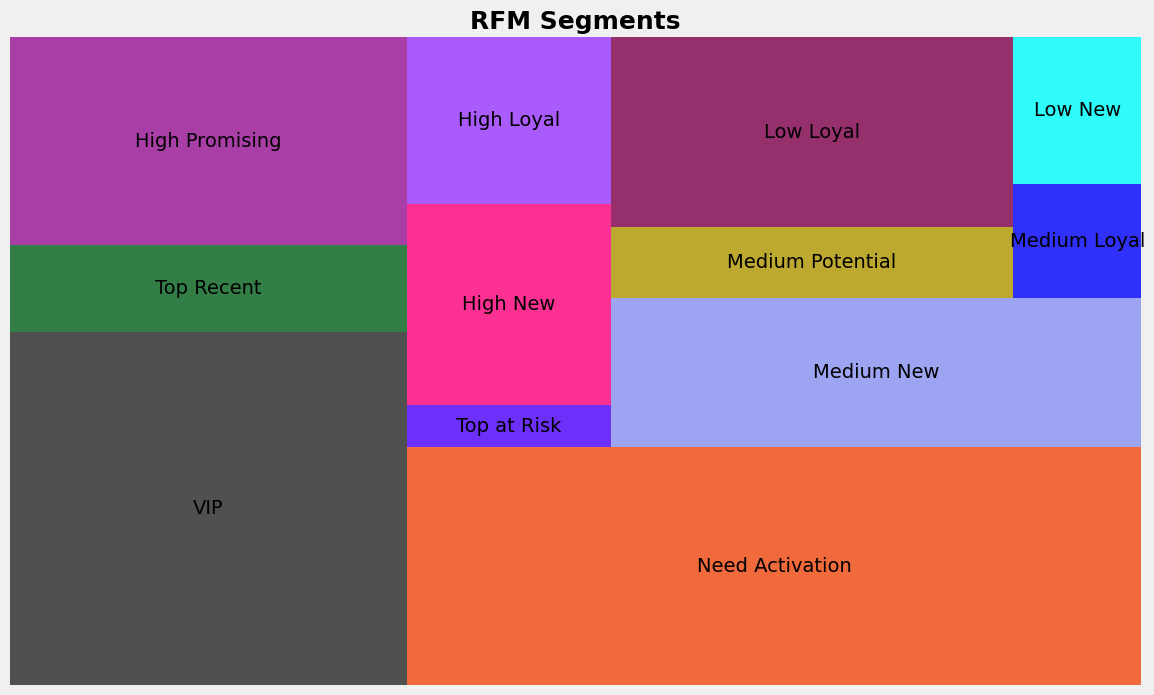

In [36]:
# Plot Segments in a Treemap


fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(13, 8)
sq.plot(sizes=segements_grouped["Customers%"], 
                      label=['VIP', 
                            "Top Recent", 
                            'High Promising', 
                            'Need Activation', 
                            'Top at Risk', 
                            'High New', 
                            'High Loyal',
                            'Medium New',
                            'Medium Potential',
                            'Low Loyal',
                            'Medium Loyal',
                            'Low New'], 
                            alpha=0.8, 
                            color=["#282828", "#04621B", "#971194", "#F1480F",  "#4C00FF", 
           "#FF007B", "#9736FF", "#8992F3", "#B29800", "#80004C", "blue", "cyan"])#"#A4E919"
plt.title("RFM Segments", fontsize=18, fontweight="bold")
plt.axis('off')
plt.show()

## Pareto Analysis - Customers Segmentation

Here we'll try to analyze what % of customers produce what % of total sales.
In this way we'll be able to identify our most valuable customers.

In [37]:
segements_grouped

Segment_labels  TotalMonetary  TotalCustomers  MeanRecency  \
11               VIP    5956527.400             830    14.580723   
9         Top Recent     792983.440             205    72.902439   
2     High Promising     549163.581             488    18.670082   
8    Need Activation     405183.300            1034   247.417795   
10      Top at Risk      302034.811              50   216.260000   
1           High New     233621.920             243    53.440329   
0         High Loyal     223176.190             201    84.179104   
6         Medium New     213847.961             468    51.382479   
7   Medium Potential      87427.800             168    21.398810   
3          Low Loyal      83207.420             454    61.374449   
5       Medium Loyal      42854.441              86    91.290698   
4            Low New      21379.640             111     9.198198   

    MeanFrequency  Monetary%  Customers%  
11      12.093976  66.841597   19.133241  
9        4.814634   8.898520    4.725680  
2        4.586066   6.162478   11.249424  
8        1.500967   4.546793   23.835869  
10       4.200000   3.389305    1.152605  
1        1.679012   2.621605    5.601660  
0        3.895522   2.504388    4.633472  
6        1.433761   2.399710   10.788382  
7        3.107143   0.981077    3.872752  
3        1.266520   0.933718   10.465652  
5        3.209302   0.480894    1.982480  
4        1.621622   0.239913    2.558783

If we observe our results we will notice that VIP and Top Recent Customers (23% of customers) produce 74% of Monetary Value (Sales), so we easily understand that the Pareto Rule also stands here. However, we will check it also with the traditonal way and we will make the plot that verifies it. 

We could apply our graph at first on our created segments and then on individual customers

In [59]:
segments_pareto = segements_grouped[["Segment_labels","TotalMonetary"]]
segments_pareto["CumulativePercentage"] = (segments_pareto["TotalMonetary"].cumsum()/ 
                                      segments_pareto["TotalMonetary"].sum()*100).round(2)


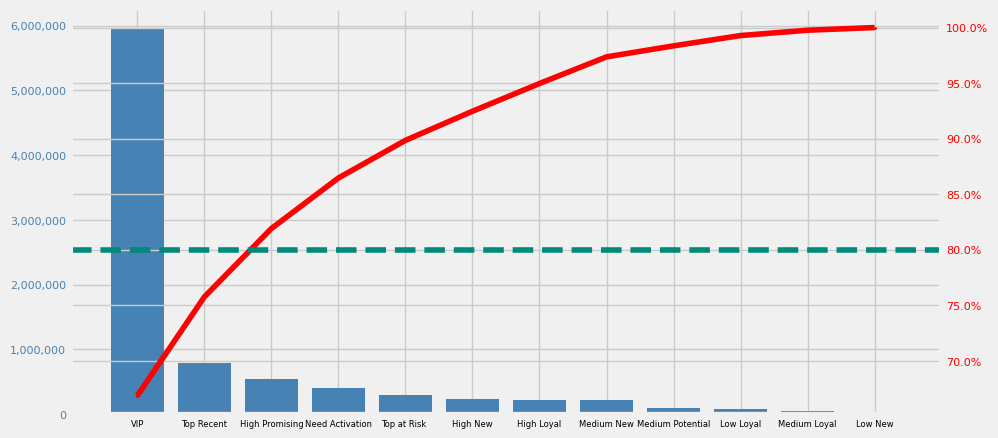

In [39]:


#define aesthetics for plot
color1 = 'steelblue'
color2 = 'red'
#line_size = 1

#create basic bar plot
fig, ax = plt.subplots()
ax.bar(segments_pareto['Segment_labels'], segments_pareto['TotalMonetary'], color=color1)


#add cumulative percentage line to plot
ax2 = ax.twinx()
ax2.plot(segments_pareto['Segment_labels'], segments_pareto['CumulativePercentage'], color=color2, marker="D", ms=1)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.axhline(80, color = "#008878", linestyle = "dashed", alpha = 1 )


    
#specify axis colors
ax.tick_params(axis='y', colors=color1, labelsize= 8)
#ax.set_xticklabels([])
ax2.tick_params(axis='y', colors=color2, labelsize= 8)

ax.tick_params(axis='x', labelsize= 6)
ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y,  p: format(int(y), ',')))

#ax.tick_params(axis='x', labelsize= )
#display Pareto chart
plt.show()

In [60]:
df_grouped = df.groupby("CustomerID").\
    agg({"TotalSales": np.sum
        })

df_grouped = df_grouped.sort_values("TotalSales", ascending = False).reset_index()
df_grouped

CustomerID  TotalSales
0         14646   280206.02
1         18102   259657.30
2         17450   194550.79
3         16446   168472.50
4         14911   143825.06
...         ...         ...
4333      16878       13.30
4334      17956       12.75
4335      16454        6.90
4336      14792        6.20
4337      16738        3.75

[4338 rows x 2 columns]

In [62]:
df_grouped["CumulativePercentage"] = (df_grouped["TotalSales"].cumsum()/ 
                                      df_grouped["TotalSales"].sum()*100).round(2)
                                      

df_grouped

CustomerID  TotalSales  CumulativePercentage
0         14646   280206.02                  3.14
1         18102   259657.30                  6.06
2         17450   194550.79                  8.24
3         16446   168472.50                 10.13
4         14911   143825.06                 11.75
...         ...         ...                   ...
4333      16878       13.30                100.00
4334      17956       12.75                100.00
4335      16454        6.90                100.00
4336      14792        6.20                100.00
4337      16738        3.75                100.00

[4338 rows x 3 columns]

In [63]:
# We focus on the part between 79,9% and 80.1% of Sales to find from which number of Customers it is produced

df_grouped[(df_grouped["CumulativePercentage"]>79.9) & (df_grouped["CumulativePercentage"]<80.1)] 

CustomerID  TotalSales  CumulativePercentage
1127      15660     1600.86                 79.92
1128      16496     1599.52                 79.93
1129      13850     1595.48                 79.95
1130      17837     1593.38                 79.97
1131      16332     1593.20                 79.99
1132      16676     1592.12                 80.01
1133      14970     1592.06                 80.02
1134      15611     1591.45                 80.04
1135      18178     1590.81                 80.06
1136      14442     1589.82                 80.08
1137      12393     1582.60                 80.09

As we observe the highest 1131-1132 customers produce 80% of total sales. Let'se see what percentage of customers they represent

In [64]:
1132/len(df_grouped)

0.26094974642692487

So we see that they represent 26% of total customers.

In this way we just found out that the highest 26% of customers produce 80% of total Sales.

So the Pareto Principle is applied almost perfectly in our example. Now let's work in order to porduce also the according plot which will also visualize it. 


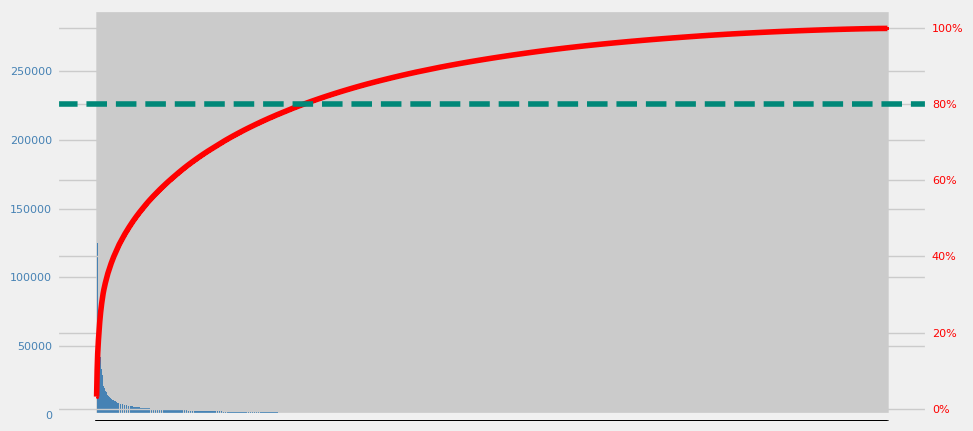

In [59]:

#define aesthetics for plot
color1 = 'steelblue'
color2 = 'red'
#line_size = 1

#create basic bar plot
fig, ax = plt.subplots()
ax.bar(df_grouped['CustomerID'], df_grouped['TotalSales'], color=color1)


#add cumulative percentage line to plot
ax2 = ax.twinx()
ax2.plot(df_grouped['CustomerID'], df_grouped['CumulativePercentage'], color=color2, marker="D", ms=1)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.axhline(80, color = "#008878", linestyle = "dashed", alpha = 1 )


    
#specify axis colors
ax.tick_params(axis='y', colors=color1, labelsize= 8)
#ax.set_xticklabels([])

ax2.tick_params(axis='y', colors=color2, labelsize= 8)

ax.tick_params(axis='x', labelsize= 1)

#ax.tick_params(axis='x', labelsize= )
#display Pareto chart
plt.show()

In [66]:
df

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice CustomerID         Country  TotalSales  \
0      2010-12-01 08:26:00       2.55      17850  United Kingdom       15.30   
1      2010-12-01 08:26:00       3.39      17850  United Kingdom       20.34   
2      2010-12-01 08:26:00       2.75      17850  United Kingdom       22.00   
3      2010-12-01 08:26:00       3.39      17850  United Kingdom       20.34   
4      2010-12-01 08:26:00       3.39      17850  United Kingdom       20.34   
...                    ...        ...        ...             ...         ...   
541904 2011-12-09 12:50:00       0.85      12680          France       10.20   
541905 2011-12-09 12:50:00       2.10      12680          France       12.60   
541906 2011-12-09 12:50:00       4.15      12680          France       16.60   
541907 2011-12-09 12:50:00       4.15      12680          France       16.60   
541908 2011-12-09 12:50:00       4.95      12680          France       14.85   

        Recency  
0           373  
1           373  
2           373  
3           373  
4           373  
...         ...  
541904        0  
541905        0  
541906        0  
541907        0  
541908        0  

[397884 rows x 10 columns]

# Market Basket Analysis / Association Rules


In [67]:
#Rank the 5 most ordered products from most to least

df.groupby("Description").agg({"Quantity":"sum"}).sort_values("Quantity", ascending=False).head(5).reset_index()

Description  Quantity
0         PAPER CRAFT , LITTLE BIRDIE     80995
1      MEDIUM CERAMIC TOP STORAGE JAR     77916
2   WORLD WAR 2 GLIDERS ASSTD DESIGNS     54415
3             JUMBO BAG RED RETROSPOT     46181
4  WHITE HANGING HEART T-LIGHT HOLDER     36725

In [86]:
#Rank the 5 products with the most sales

df.groupby("Description").agg({"TotalSales":"sum"}).sort_values("TotalSales", ascending=False).head(5).reset_index()

Description  TotalSales
0         PAPER CRAFT , LITTLE BIRDIE   168469.60
1            REGENCY CAKESTAND 3 TIER   142592.95
2  WHITE HANGING HEART T-LIGHT HOLDER   100448.15
3             JUMBO BAG RED RETROSPOT    85220.78
4      MEDIUM CERAMIC TOP STORAGE JAR    81416.73

In [87]:
# inputs
supp = 10 # minimum support of an assoc. rule (default: 10)
conf = 50 # minimum confidence of an assoc. rule (default: 80%)
report = 'aSCl'

In [88]:
report_colnames = {
    'a': 'support_itemset_absolute',
    's': 'support_itemset_relative',
    'S': 'support_itemset_relative_pct',
    'b': 'support_bodyset_absolute',
    'x': 'support_bodyset_relative',
    'X': 'support_bodyset_relative_pct',
    'h': 'support_headitem_absolute',
    'y': 'support_headitem_relative',
    'Y': 'support_headitem_relative_pct',
    'c': 'confidence',
    'C': 'confidence_pct',
    'l': 'lift',
    'L': 'lift_pct',
    'e': 'evaluation',
    'E': 'evaluation_pct',
    'Q': 'support of the empty set (total number of transactions)'
    }

In [274]:
# display docs
#??arules

In [89]:
Customers_Products=df.groupby('CustomerID')['Description'].apply(list)
Customers_Products

CustomerID
12346                     [MEDIUM CERAMIC TOP STORAGE JAR]
12347    [BLACK CANDELABRA T-LIGHT HOLDER, AIRLINE BAG ...
12348    [72 SWEETHEART FAIRY CAKE CASES, 60 CAKE CASES...
12349    [PARISIENNE CURIO CABINET, SWEETHEART WALL TID...
12350    [CHOCOLATE THIS WAY METAL SIGN, METAL SIGN NEI...
                               ...                        
18280    [WOOD BLACK BOARD ANT WHITE FINISH, RETROSPOT ...
18281    [ROBOT BIRTHDAY CARD, CARD CIRCUS PARADE, PENN...
18282    [ANTIQUE CREAM CUTLERY CUPBOARD, FRENCH STYLE ...
18283    [CHARLOTTE BAG PINK POLKADOT, LUNCH BAG WOODLA...
18287    [SMALL PURPLE BABUSHKA NOTEBOOK , SMALL RED BA...
Name: Description, Length: 4338, dtype: object

In [90]:

# Create list only with Customers and Products
Customers_Products=df.groupby('CustomerID')['Description'].apply(list)


# Create list of lists to pass it into PyFim

Customers_Products_List=Customers_Products.to_list()
Customers_Products_List

[['MEDIUM CERAMIC TOP STORAGE JAR'],
 ['BLACK CANDELABRA T-LIGHT HOLDER',
  'AIRLINE BAG VINTAGE JET SET BROWN',
  'COLOUR GLASS. STAR T-LIGHT HOLDER',
  'MINI PAINT SET VINTAGE ',
  'CLEAR DRAWER KNOB ACRYLIC EDWARDIAN',
  'PINK DRAWER KNOB ACRYLIC EDWARDIAN',
  'GREEN DRAWER KNOB ACRYLIC EDWARDIAN',
  'RED DRAWER KNOB ACRYLIC EDWARDIAN',
  'PURPLE DRAWERKNOB ACRYLIC EDWARDIAN',
  'BLUE DRAWER KNOB ACRYLIC EDWARDIAN',
  'ALARM CLOCK BAKELIKE CHOCOLATE',
  'ALARM CLOCK BAKELIKE GREEN',
  'ALARM CLOCK BAKELIKE RED ',
  'ALARM CLOCK BAKELIKE PINK',
  'ALARM CLOCK BAKELIKE ORANGE',
  'FOUR HOOK  WHITE LOVEBIRDS',
  'BLACK GRAND BAROQUE PHOTO FRAME',
  'BATHROOM METAL SIGN ',
  'LARGE HEART MEASURING SPOONS',
  'BOX OF 6 ASSORTED COLOUR TEASPOONS',
  'BLUE 3 PIECE POLKADOT CUTLERY SET',
  'RED 3 PIECE RETROSPOT CUTLERY SET',
  'PINK 3 PIECE POLKADOT CUTLERY SET',
  'EMERGENCY FIRST AID TIN ',
  'SET OF 2 TINS VINTAGE BATHROOM ',
  'SET/3 DECOUPAGE STACKING TINS',
  'BOOM BOX SPEAKER BOYS',

In [93]:
# Run apriori algorithm to creeate associations
result = arules(Customers_Products_List, supp=supp, conf=conf, report=report)

#Uncomment and run in case you want to see parameters of association rules
#??arules


#Creat dataframe wiht columns based on the report variables and sorted based on the "Associations_Sorted_based_on"
colnames = ['Cons_Product', 'antecedent'] + [report_colnames.get(k, k) for k in list(report)]
df_rules = pd.DataFrame(result, columns=colnames)
df_rules = df_rules.sort_values(report_colnames["a"], ascending=False)

#Change order of columns antecedent and consequent
df_rules = df_rules[['antecedent', 'Cons_Product']+ [report_colnames.get(k, k) for k in list(report)]]


#Print the numbers of rules created
print(df_rules.shape)

#Print top 10 and last 10 rules (the last 10 will be shown)
df_rules.head(5)


(36, 6)


antecedent                       Cons_Product  \
25    (PAPER CHAIN KIT 50'S CHRISTMAS ,)  PAPER CHAIN KIT VINTAGE CHRISTMAS   
24  (PAPER CHAIN KIT VINTAGE CHRISTMAS,)    PAPER CHAIN KIT 50'S CHRISTMAS    
29              (HEART OF WICKER SMALL,)              HEART OF WICKER LARGE   
28              (HEART OF WICKER LARGE,)              HEART OF WICKER SMALL   
8                 (LUNCH BAG CARS BLUE,)            LUNCH BAG RED RETROSPOT   

    support_itemset_absolute  support_itemset_relative_pct  confidence_pct  \
25                       327                      7.538036       53.344209   
24                       327                      7.538036       69.574468   
29                       308                      7.100046       53.752182   
28                       308                      7.100046       63.505155   
8                        308                      7.100046       64.300626   

        lift  
25  4.923557  
24  4.923557  
29  4.807772  
28  4.807772  
8   5.243160

The df_rules table is sorted according a = support_itemset_absolute so the top five combinations of 
products that are most found together are:

1) PAPER CHAIN KIT 50'S CHRISTMAS and PAPER CHAIN KIT VINTAGE CHRISTMAS 327 times

2)PAPER CHAIN KIT VINTAGE CHRISTMAS and	PAPER CHAIN KIT 50'S CHRISTMAS also 327 times

3)HEART OF WICKER SMALL and PAPER CHAIN KIT 50'S CHRISTMAS	308 times

4)HEART OF WICKER LARGE and HEART OF WICKER SMALL 308 times 

5)LUNCH BAG CARS BLUE and LUNCH BAG RED RETROSPOT 308 times




In [94]:
df_rules.sort_values(by=['confidence_pct'], ascending=False).head(5)

antecedent                     Cons_Product  \
24  (PAPER CHAIN KIT VINTAGE CHRISTMAS,)  PAPER CHAIN KIT 50'S CHRISTMAS    
15            (LUNCH BAG PINK POLKADOT,)          LUNCH BAG RED RETROSPOT   
4             (LUNCH BAG  BLACK SKULL.,)          LUNCH BAG RED RETROSPOT   
8                 (LUNCH BAG CARS BLUE,)          LUNCH BAG RED RETROSPOT   
21            (LUNCH BAG PINK POLKADOT,)              LUNCH BAG CARS BLUE   

    support_itemset_absolute  support_itemset_relative_pct  confidence_pct  \
24                       327                      7.538036       69.574468   
15                       295                      6.800369       66.441441   
4                        300                      6.915629       65.502183   
8                        308                      7.100046       64.300626   
21                       284                      6.546796       63.963964   

        lift  
24  4.923557  
15  5.417725  
4   5.341137  
8   5.243160  
21  5.792812

Now we have sorted our df based on confidence_pct which shows how many times customers that have firstly bought
the antecedent product buy also the consequent product. The top 5 relationships show the below.



1) 69% of customers that have already bought
PAPER CHAIN KIT VINTAGE CHRISTMAS buy after PAPER CHAIN KIT 50'S CHRISTMAS

2)66% of customers that have already bought
LUNCH BAG PINK POLKADOT buy after LUNCH BAG RED RETROSPOT

3)65% of customers that have already bought
LUNCH BAG BLACK SKULL buy after LUNCH BAG RED RETROSPOT

4)64.3% of customers that have already bought
LUNCH BAG CARS BLUE buy after LUNCH BAG RED RETROSPOT	

5)63.9% of customers that have already bought
LUNCH BAG PINK POLKADOT buy after LUNCH BAG CARS BLUE	



In [95]:
df_rules.sort_values(by=['lift'], ascending=False).head(5)

antecedent             Cons_Product  \
35  (LUNCH BAG SPACEBOY DESIGN ,)       LUNCH BAG WOODLAND   
33         (LUNCH BAG CARS BLUE,)   LUNCH BAG SUKI DESIGN    
32     (LUNCH BAG  BLACK SKULL.,)   LUNCH BAG SUKI DESIGN    
19     (LUNCH BAG PINK POLKADOT,)  LUNCH BAG  BLACK SKULL.   
20     (LUNCH BAG  BLACK SKULL.,)  LUNCH BAG PINK POLKADOT   

    support_itemset_absolute  support_itemset_relative_pct  confidence_pct  \
35                       261                      6.016598       53.265306   
33                       271                      6.247118       56.576200   
32                       254                      5.855233       55.458515   
19                       279                      6.431535       62.837838   
20                       279                      6.431535       60.917031   

        lift  
35  6.211422  
33  6.151067  
32  6.029550  
19  5.951759  
20  5.951759

Now we have sorted our df based on lift which shows how many times more probable a customer is to buy the
consequent product after he/she had already bought the antecedent product in comparison to any random customer.


1) A customer that have already bought LUNCH BAG SPACEBOY DESIGN
are 6.2 times more probable to buy LUNCH BAG WOODLAND in comparison to any other random customer.


2) A customer that have already bought LUNCH BAG CARS BLUE
are 6.1 times more probable to buy LUNCH BAG SUKI DESIGN in comparison to any other random customer.

3) A customer that have already bought LUNCH BAG BLACK SKULL
are 6 times more probable to buy LUNCH BAG SUKI DESIGN in comparison to any other random customer.

4) A customer that have already bought LUNCH BAG PINK POLKADOT
are 5.9 times more probable to buy LUNCH BAG BLACK SKULL in comparison to any other random customer.

5) A customer that have already bought LUNCH BAG BLACK SKULL
are 5.9 times more probable to buy LUNCH BAG PINK POLKADOT in comparison to any other random customer.


## Cohort Analysis  

In [74]:
# Create the cohort and order_month variables

df['order_month'] = df['InvoiceDate'].dt.to_period('M')

In [75]:
df['cohort']= df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')
df

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice CustomerID         Country  TotalSales  \
0      2010-12-01 08:26:00       2.55      17850  United Kingdom       15.30   
1      2010-12-01 08:26:00       3.39      17850  United Kingdom       20.34   
2      2010-12-01 08:26:00       2.75      17850  United Kingdom       22.00   
3      2010-12-01 08:26:00       3.39      17850  United Kingdom       20.34   
4      2010-12-01 08:26:00       3.39      17850  United Kingdom       20.34   
...                    ...        ...        ...             ...         ...   
541904 2011-12-09 12:50:00       0.85      12680          France       10.20   
541905 2011-12-09 12:50:00       2.10      12680          France       12.60   
541906 2011-12-09 12:50:00       4.15      12680          France       16.60   
541907 2011-12-09 12:50:00       4.15      12680          France       16.60   
541908 2011-12-09 12:50:00       4.95      12680          France       14.85   

        Recency order_month   cohort  
0           373     2010-12  2010-12  
1           373     2010-12  2010-12  
2           373     2010-12  2010-12  
3           373     2010-12  2010-12  
4           373     2010-12  2010-12  
...         ...         ...      ...  
541904        0     2011-12  2011-08  
541905        0     2011-12  2011-08  
541906        0     2011-12  2011-08  
541907        0     2011-12  2011-08  
541908        0     2011-12  2011-08  

[397884 rows x 12 columns]

In [76]:
#We aggregate the data per cohort and order_month and count the number of unique customers in each group.

df_cohort = df.groupby(['cohort', 'order_month']).agg(n_customers=('CustomerID',
                                                                   'nunique')).reset_index(drop=False)

In [77]:

df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))
df_cohort

cohort order_month  n_customers  period_number
0   2010-12     2010-12          885              0
1   2010-12     2011-01          324              1
2   2010-12     2011-02          286              2
3   2010-12     2011-03          340              3
4   2010-12     2011-04          321              4
..      ...         ...          ...            ...
86  2011-10     2011-11           86              1
87  2011-10     2011-12           41              2
88  2011-11     2011-11          323              0
89  2011-11     2011-12           36              1
90  2011-12     2011-12           41              0

[91 rows x 4 columns]

In [78]:
# We aggregate the data per cohort and order_month and count the number of unique customers in each group.

cohort_pivot = df_cohort.pivot_table(index='cohort', 
                                     columns='period_number', 
                                     values='n_customers')
cohort_pivot

period_number     0      1      2      3      4      5      6      7      8   \
cohort                                                                         
2010-12        885.0  324.0  286.0  340.0  321.0  352.0  321.0  309.0  313.0   
2011-01        417.0   92.0  111.0   96.0  134.0  120.0  103.0  101.0  125.0   
2011-02        380.0   71.0   71.0  108.0  103.0   94.0   96.0  106.0   94.0   
2011-03        452.0   68.0  114.0   90.0  101.0   76.0  121.0  104.0  126.0   
2011-04        300.0   64.0   61.0   63.0   59.0   68.0   65.0   78.0   22.0   
2011-05        284.0   54.0   49.0   49.0   59.0   66.0   75.0   27.0    NaN   
2011-06        242.0   42.0   38.0   64.0   56.0   81.0   23.0    NaN    NaN   
2011-07        188.0   34.0   39.0   42.0   51.0   21.0    NaN    NaN    NaN   
2011-08        169.0   35.0   42.0   41.0   21.0    NaN    NaN    NaN    NaN   
2011-09        299.0   70.0   90.0   34.0    NaN    NaN    NaN    NaN    NaN   
2011-10        358.0   86.0   41.0    NaN    NaN    NaN    NaN    NaN    NaN   
2011-11        323.0   36.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2011-12         41.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

period_number     9      10     11     12  
cohort                                     
2010-12        350.0  331.0  445.0  235.0  
2011-01        136.0  152.0   49.0    NaN  
2011-02        116.0   26.0    NaN    NaN  
2011-03         39.0    NaN    NaN    NaN  
2011-04          NaN    NaN    NaN    NaN  
2011-05          NaN    NaN    NaN    NaN  
2011-06          NaN    NaN    NaN    NaN  
2011-07          NaN    NaN    NaN    NaN  
2011-08          NaN    NaN    NaN    NaN  
2011-09          NaN    NaN    NaN    NaN  
2011-10          NaN    NaN    NaN    NaN  
2011-11          NaN    NaN    NaN    NaN  
2011-12          NaN    NaN    NaN    NaN

The table above shows exactly what we want however we want to canvert it into a more clear table.

In [79]:
cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)


In the end we plot the retention matrix as a heatmap.
In order to show also the sizes of each cohort size, we created two heatmaps, where the one indicating the cohort size is using a white only colormap — grey color.


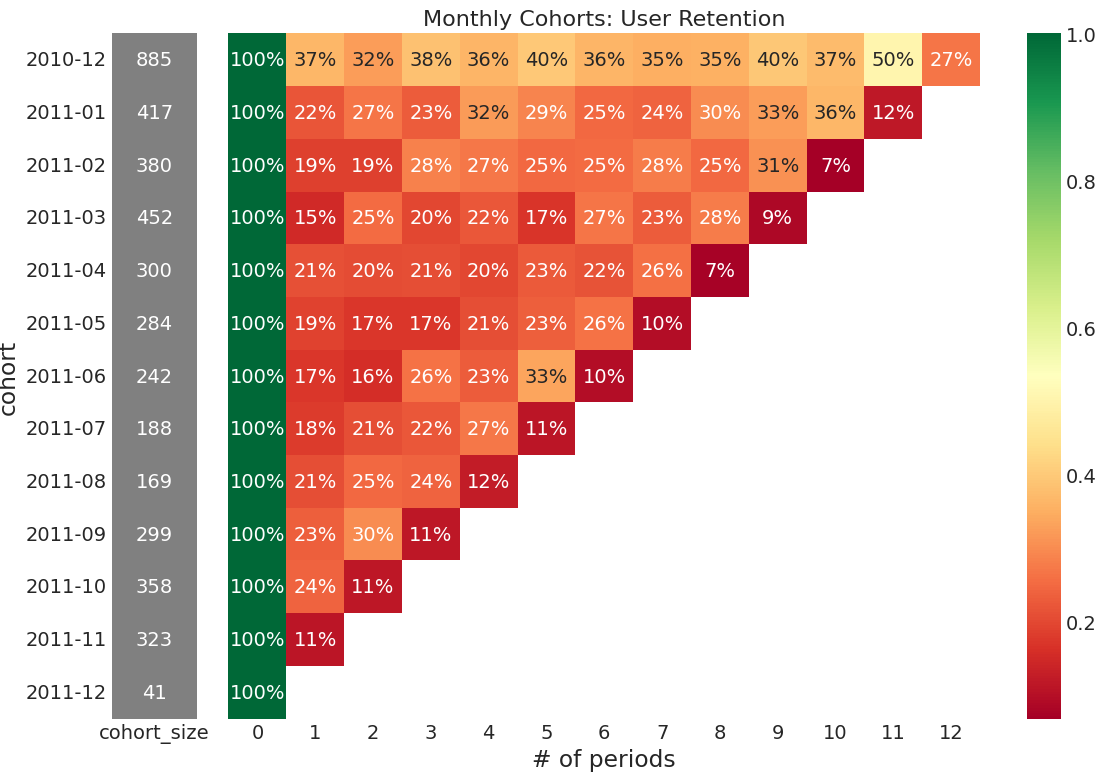

In [80]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['grey'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

 By excluding first and last cohort the top 3 cohorts by sizes are:
 
 1) cohort 2011-03 with size 452 new customers
 
 2) cohort 2011-01 with size 417 new customers
 
 3) cohort 2011-02 with size 380 new customers
 
 

Also by including all cohorts,

the cohort with the highest customer retention is cohort 2010-12, 11 months after the initial buy having 50% customer retention.



On the other hand, the cohorts with the lowest customer retention are cohorts:

2011-02, 10 months after the initial buy, having only 7% customer retention and also 

2011-04, 8 months after the initial buy, having again only 7% customer retention
